In [1]:
#Boiler plate imports
import pandas as pd
import sys
from time import time
import matplotlib.pyplot as plt
import numpy as np

#SBND imports
s0 = time()
sys.path.append('/exp/sbnd/app/users/brindenc/analyze_sbnd/pyana')
from sbnd.general import utils
from sbnd.cafclasses.slice import CAFSlice
from sbnd.cafclasses.pfp import PFP

#Constants
from sbnd.numu.numu_constants import *
from sbnd.flux.prism import PRISM_BINS
from sbnd.constants import *

#Plotters
from sbnd.plotlibrary import makeplot
from sbnd.general import plotters
from sbnd.detector.volume import plot_volume_boundary

s1 = time()
print(f'SBND imports: {s1-s0:.2f} s')

%load_ext autoreload
%autoreload 2

SBND imports: 92.97 s


## 1. Load Data

In [12]:
#Constants/variables
CUT_MODE = 'roc_cont'
#DATA_DIR  = '/exp/sbnd/data/users/brindenc/analyze_sbnd/numu/v09_78_04_wc_pandora'
#DATA_DIR = '/exp/sbnd/data/users/brindenc/ML/test_fcl/debug_trackid/v4'
DATA_DIR = '/exp/sbnd/data/users/brindenc/analyze_sbnd/numu/v09_82_02_01_pds_gain'
#FNAME = f'single_processed_{CUT_MODE}.df'
#FNAME = 'single_cut_cosmics_processed.df'
#HDR_FNAME = 'single.df'
FNAME = f'nom_processed_{CUT_MODE}.df'
HDR_FNAME = 'nom.df'
#FNAME = f'all_processed_{CUT_MODE}.df'
#HDR_FNAME = 'all.df'
#FNAME = 'test_processed.df'
#HDR_FNAME = 'test.df'
NOM_POT = 10e20 # stats for first run
LABEL = 'SBND Work in Progress\nSimulation'
PLOT_DIR = f'Plots/10e20/reco_{plotters.day}_{CUT_MODE}'
SAVE_PLOT = True

plt.style.use('/exp/sbnd/app/users/brindenc/analyze_sbnd/pyana/sbnd/plotlibrary/plot.mplstyle')

In [31]:
#Get data and POT
pfp = PFP.load(f'{DATA_DIR}/{FNAME}','pfp'
               ,prism_bins=PRISM_BINS
               ,momentum_bins=MOMENTUM_BINS
               ,costheta_bins=COSTHETA_BINS
               ,pot=NOM_POT)
slc = CAFSlice.load(f'{DATA_DIR}/{FNAME}','slice'
                    ,prism_bins=PRISM_BINS
                    ,pot=NOM_POT)
hdr = pd.read_hdf(f'{DATA_DIR}/{HDR_FNAME}',key='hdr')
SAMPLE_POT = hdr.pot.sum()

#Scale to nominal POT
print(f'--scaled by {NOM_POT/SAMPLE_POT:.2f}')
pfp.scale_to_pot(NOM_POT,SAMPLE_POT)
slc.scale_to_pot(NOM_POT,SAMPLE_POT)

--scaled by 134.14
--scaling to POT: 7.45e+18 -> 1.00e+21
--scaling to POT: 7.45e+18 -> 1.00e+21


In [32]:
CUTS = ['cosmic','fv','trk','muon']
CUTS_CONT = CUTS + ['cont']
pur,eff,f1 = slc.get_pur_eff_f1(CUTS_CONT)
pur,eff,f1

(array([0.05938773, 0.66998959, 0.81843083, 0.86394197, 0.92476599,
        0.94121271]),
 array([1.        , 0.70374904, 0.56825883, 0.53371953, 0.46217073,
        0.23379604]),
 array([1.        , 0.6864545 , 0.67077812, 0.65982028, 0.61632195,
        0.37455348]))

## 2 True event type distributions

In [33]:
#Get interaction types - won't work if there are no events of a given type
#slc_unk = CAFSlice(slc.data[slc.data.truth.event_type == -1])
slc_numucc = CAFSlice(slc.data[slc.data.truth.event_type == 0])
slc_nc = CAFSlice(slc.data[slc.data.truth.event_type == 1])
slc_nuecc = CAFSlice(slc.data[slc.data.truth.event_type == 2])
slc_cosmic = CAFSlice(slc.data[slc.data.truth.event_type == 3])
slc_dirt = CAFSlice(slc.data[slc.data.truth.event_type == 4])
slcs = [slc_numucc,slc_nc,slc_nuecc,slc_cosmic,slc_dirt]

#Get associated PFPs
#pfp_unk = pfp.get_reference_df(slc_unk)
pfp_numucc_df = pfp.get_reference_df(slc_numucc)
pfp_nc_df = pfp.get_reference_df(slc_nc)
pfp_nuecc_df = pfp.get_reference_df(slc_nuecc)
pfp_cosmic_df = pfp.get_reference_df(slc_cosmic)
pfp_dirt_df = pfp.get_reference_df(slc_dirt)

pfp_dfs = [pfp_numucc_df,pfp_nc_df,pfp_nuecc_df,pfp_cosmic_df,pfp_dirt_df]

In [34]:
#Get label info
labels = []
names = []
colors = []

for key,item in EVENT_TYPE_LIST.items():
    if key == -1: #no unknown for now
        continue
    labels.append(item[0])
    names.append(item[1])
    colors.append(item[2])

weights = [s.data.genweight for s in slcs]

### 2.1 Histograms

In [35]:
def create_hist(series,labels,dens,cut_desc='',xlabel='',colors=None,weights=None,bins=20,cut='',savename='hist'
                ,stat_label=''):
    
    if dens:
        histtype = 'step'
        alpha = 0.9
    else:
        histtype = 'barstacked'
        alpha = 0.8
    fig,ax = makeplot.plot_hist(series,labels,xlabel=xlabel,colors=colors,weights=weights
                   ,histtype=histtype,lw=2,bins=bins,alpha=alpha,density=dens)
    if dens: ax.set_ylabel('Density')
    else: ax.set_ylabel('Events')
    plotters.add_label(ax,LABEL,where='topleft',color='gray',alpha=0.9,fontsize=10)
    plotters.add_label(ax,stat_label,where='bottomrightoutside',fontsize=10)
    plotters.add_label(ax,cut_desc,where='bottomrightoutside',color='black',fontsize=12)
    plotters.set_style(ax)
    if SAVE_PLOT:
        if dens: plot_dir = f'{PLOT_DIR}/{cut}/dens'
        else: plot_dir = f'{PLOT_DIR}/{cut}/counts'
        plotters.save_plot(f'{savename}',fig=fig,folder_name=plot_dir)
        plt.close('all')
    return fig,ax

In [38]:
_slcs = [s.copy() for s in slcs]
_weights = [w.copy() for w in weights]
cut = 'precut'
for i,cut in enumerate(['precut']+CUTS_CONT):
    #Apply cut
    if cut != 'precut':
        [s.apply_cut(cut) for s in _slcs] 
    #if cut != 'muon': continue #just show final event rates
    _weights = [s.data.genweight for s in _slcs] 
    cut_desc = f'{cut}:' + '\n' + f'Pur = {pur[i]:.2f}' + '\n' + f'Eff = {eff[i]:.2f}' + '\n' + f'F1 = {f1[i]:.2f}'  
    
    #Best muon info
    costheta = [s.data.best_muon.costheta for s in _slcs]
    momentum = [s.data.best_muon.p for s in _slcs]
    tcostheta = [s.data.best_muon.truth.p.costheta for s in _slcs]
    tmomentum = [s.data.best_muon.truth.p.genp.tot for s in _slcs]

    #Scores
    nu_scores = [s.data.nu_score for s in _slcs]
    fmatch_scores = [s.data.fmatch.score for s in _slcs]
    opt0_x2 = [1/s.data.opt0.score for s in _slcs] #x2 score
    best_trk_scores = [s.data.best_trk_score for s in _slcs]

    #Vertex location
    vertexx = [s.data.vertex.x for s in _slcs]
    vertexy = [s.data.vertex.y for s in _slcs]
    vertexz = [s.data.vertex.z for s in _slcs]
    tvertexx = [s.data.truth.position.x for s in _slcs]
    tvertexy = [s.data.truth.position.y for s in _slcs]
    tvertexz = [s.data.truth.position.z for s in _slcs]

    #Number of particles
    npfps = [s.data.npfp for s in _slcs]
    ntrks = [s.data.ntrk for s in _slcs]
    nshws = [s.data.nshw for s in _slcs]
    tnpfps = [s.data.truth.npfp for s in _slcs]
    tntrks = [s.data.truth.ntrk for s in _slcs]
    tnshws = [s.data.truth.nshw for s in _slcs]

    nmuons = [s.data.reco.pdg_13 for s in _slcs]
    tnmuons = [s.data.truth.pdg_13 for s in _slcs]

    #Bins
    nbins = np.arange(0,10,1)
    bdt_bins = np.arange(-0.05,1.05,0.05)
    for dens in [False,True]:
        if dens: plot_dir = f'{PLOT_DIR}/{cut}/dens'
        else: plot_dir = f'{PLOT_DIR}/{cut}/counts'
        #Reco costheta
        fig,ax = create_hist(costheta,labels,dens,cut_desc=cut_desc,xlabel=r'$\cos\theta_{\mu,reco}$',colors=colors,weights=_weights,bins=np.arange(-1,1.1,0.1),cut=cut,savename='reco_costheta')
        #Reco momentum
        fig,ax = create_hist(momentum,labels,dens,cut_desc=cut_desc,xlabel=r'Reco $p_{\mu,reco}$ [GeV]',colors=colors,weights=_weights,bins=np.arange(0,2.5,0.1),cut=cut,savename='reco_momentum')
        #Truth costheta
        fig,ax = create_hist(tcostheta,labels,dens,cut_desc=cut_desc,xlabel=r'$\cos\theta_{\mu,truth}$',colors=colors,weights=_weights,bins=np.arange(-1,1.1,0.1),cut=cut,savename='true_costheta')
        #Truth momentum
        fig,ax = create_hist(tmomentum,labels,dens,cut_desc=cut_desc,xlabel=r'Truth $p_{\mu,truth}$ [GeV]',colors=colors,weights=_weights,bins=np.arange(0,2.5,0.1),cut=cut,savename='true_momentum')
        #Number of reco muons
        fig,ax = create_hist(nmuons,labels,dens,cut_desc=cut_desc,xlabel=r'Reconstructed Muons',colors=colors,weights=_weights,bins=nbins,cut=cut,savename='nmu')
        #Pandora nu score
        fig,ax = create_hist(nu_scores,labels,dens,cut_desc=cut_desc,xlabel=r'Pandora $\nu$-score',colors=colors,weights=_weights,bins=bdt_bins,cut=cut,savename='nu_score')
        #Flash matching score hist
        fig,ax = create_hist(fmatch_scores,labels,dens,cut_desc=cut_desc,xlabel='Flash match score',colors=colors,weights=_weights,bins=np.arange(0,50,2),cut=cut,savename='fmatch_score')
        #opt0 score
        fig,ax = create_hist(opt0_x2,labels,dens,cut_desc=cut_desc,xlabel=r'OpT0 $\chi^2$ (1/Score)',colors=colors,weights=_weights,bins=np.logspace(-5,1,100),cut=cut,savename='opt0_score')
        ax.set_xscale('log')
        plotters.save_plot(f'opt0_score',fig=fig,folder_name=plot_dir)
        #PFP
        fig,ax = create_hist(npfps,labels,dens,cut_desc=cut_desc,xlabel=r'Number of PFPs',colors=colors,weights=_weights,bins=nbins,cut=cut,savename='npfp')
        #Trks
        fig,ax = create_hist(ntrks,labels,dens,cut_desc=cut_desc,xlabel=r'Number of tracks',colors=colors,weights=_weights,bins=nbins,cut=cut,savename='ntrk')
        #Shws
        fig,ax = create_hist(nshws,labels,dens,cut_desc=cut_desc,xlabel=r'Number of showers',colors=colors,weights=_weights,bins=nbins,cut=cut,savename='nshw')
        #Truth PFP
        fig,ax = create_hist(tnpfps,labels,dens,cut_desc=cut_desc,xlabel=r'Number of truth PFPs',colors=colors,weights=_weights,bins=nbins,cut=cut,savename='tnpfp')
        #Truth Trks
        fig,ax = create_hist(tntrks,labels,dens,cut_desc=cut_desc,xlabel=r'Number of truth tracks',colors=colors,weights=_weights,bins=nbins,cut=cut,savename='tntrk')
        #Truth Shws
        fig,ax = create_hist(tnshws,labels,dens,cut_desc=cut_desc,xlabel=r'Number of truth showers',colors=colors,weights=_weights,bins=nbins,cut=cut,savename='tnshw')
        #Best track score
        fig,ax = create_hist(best_trk_scores,labels,dens,cut_desc=cut_desc,xlabel=r'Pandora Track Score',colors=colors,weights=_weights,bins=bdt_bins,cut=cut,savename='best_trk_score')
        #Vertex location
        fig,ax = create_hist(vertexx,labels,dens,cut_desc=cut_desc,xlabel=r'Vertex x [cm]',colors=colors,weights=_weights,bins=np.arange(-300,310,10),cut=cut,savename='vertex_x')
        fig,ax = create_hist(vertexy,labels,dens,cut_desc=cut_desc,xlabel=r'Vertex y [cm]',colors=colors,weights=_weights,bins=np.arange(-300,310,10),cut=cut,savename='vertex_y')
        fig,ax = create_hist(vertexz,labels,dens,cut_desc=cut_desc,xlabel=r'Vertex z [cm]',colors=colors,weights=_weights,bins=np.arange(-100,610,10),cut=cut,savename='vertex_z')
        #True vertex location
        fig,ax = create_hist(tvertexx,labels,dens,cut_desc=cut_desc,xlabel=r'Truth Vertex x [cm]',colors=colors,weights=_weights,bins=np.arange(-300,310,10),cut=cut,savename='tvertex_x')
        fig,ax = create_hist(tvertexy,labels,dens,cut_desc=cut_desc,xlabel=r'Truth Vertex y [cm]',colors=colors,weights=_weights,bins=np.arange(-300,310,10),cut=cut,savename='tvertex_y')
        fig,ax = create_hist(tvertexz,labels,dens,cut_desc=cut_desc,xlabel=r'Truth Vertex z [cm]',colors=colors,weights=_weights,bins=np.arange(-100,610,10),cut=cut,savename='tvertex_z')

/exp/sbnd/app/users/brindenc/env_al9/lib64/python3.9/site-packages/numpy/lib/histograms.py:461: RuntimeWarning: invalid value encountered in cast
  a.searchsorted(v[:-1], 'left'),
/exp/sbnd/app/users/brindenc/env_al9/lib64/python3.9/site-packages/numpy/lib/histograms.py:462: RuntimeWarning: invalid value encountered in cast
  a.searchsorted(v[-1:], 'right')
/exp/sbnd/app/users/brindenc/env_al9/lib64/python3.9/site-packages/matplotlib/axes/_axes.py:6973: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/exp/sbnd/app/users/brindenc/env_al9/lib64/python3.9/site-packages/matplotlib/axes/_axes.py:6974: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
/exp/sbnd/app/users/brindenc/env_al9/lib64/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Applied cut on key: cut.cosmic (45,745 --> 32,193)
Applied cut on key: cut.cosmic (10,550 --> 4,761)
Applied cut on key: cut.cosmic (353 --> 284)
Applied cut on key: cut.cosmic (689,004 --> 577)
Applied cut on key: cut.cosmic (24,625 --> 10,235)


/exp/sbnd/app/users/brindenc/env_al9/lib64/python3.9/site-packages/matplotlib/axes/_axes.py:6973: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/exp/sbnd/app/users/brindenc/env_al9/lib64/python3.9/site-packages/matplotlib/axes/_axes.py:6974: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
/exp/sbnd/app/users/brindenc/env_al9/lib64/python3.9/site-packages/numpy/lib/histograms.py:461: RuntimeWarning: invalid value encountered in cast
  a.searchsorted(v[:-1], 'left'),
/exp/sbnd/app/users/brindenc/env_al9/lib64/python3.9/site-packages/numpy/lib/histograms.py:462: RuntimeWarning: invalid value encountered in cast
  a.searchsorted(v[-1:], 'right')
/exp/sbnd/app/users/brindenc/env_al9/lib64/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Applied cut on key: cut.fv (32,193 --> 25,995)
Applied cut on key: cut.fv (4,761 --> 3,885)
Applied cut on key: cut.fv (284 --> 236)
Applied cut on key: cut.fv (577 --> 322)
Applied cut on key: cut.fv (10,235 --> 1,324)


/exp/sbnd/app/users/brindenc/env_al9/lib64/python3.9/site-packages/matplotlib/axes/_axes.py:6973: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/exp/sbnd/app/users/brindenc/env_al9/lib64/python3.9/site-packages/matplotlib/axes/_axes.py:6974: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
/exp/sbnd/app/users/brindenc/env_al9/lib64/python3.9/site-packages/numpy/lib/histograms.py:461: RuntimeWarning: invalid value encountered in cast
  a.searchsorted(v[:-1], 'left'),
/exp/sbnd/app/users/brindenc/env_al9/lib64/python3.9/site-packages/numpy/lib/histograms.py:462: RuntimeWarning: invalid value encountered in cast
  a.searchsorted(v[-1:], 'right')
/exp/sbnd/app/users/brindenc/env_al9/lib64/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Applied cut on key: cut.trk (25,995 --> 24,415)
Applied cut on key: cut.trk (3,885 --> 2,431)
Applied cut on key: cut.trk (236 --> 116)
Applied cut on key: cut.trk (322 --> 250)
Applied cut on key: cut.trk (1,324 --> 1,048)


/exp/sbnd/app/users/brindenc/env_al9/lib64/python3.9/site-packages/matplotlib/axes/_axes.py:6973: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/exp/sbnd/app/users/brindenc/env_al9/lib64/python3.9/site-packages/matplotlib/axes/_axes.py:6974: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
/exp/sbnd/app/users/brindenc/env_al9/lib64/python3.9/site-packages/numpy/lib/histograms.py:461: RuntimeWarning: invalid value encountered in cast
  a.searchsorted(v[:-1], 'left'),
/exp/sbnd/app/users/brindenc/env_al9/lib64/python3.9/site-packages/numpy/lib/histograms.py:462: RuntimeWarning: invalid value encountered in cast
  a.searchsorted(v[-1:], 'right')
/exp/sbnd/app/users/brindenc/env_al9/lib64/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Applied cut on key: cut.muon (24,415 --> 21,142)
Applied cut on key: cut.muon (2,431 --> 620)
Applied cut on key: cut.muon (116 --> 26)
Applied cut on key: cut.muon (250 --> 206)
Applied cut on key: cut.muon (1,048 --> 868)


/exp/sbnd/app/users/brindenc/env_al9/lib64/python3.9/site-packages/matplotlib/axes/_axes.py:6973: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/exp/sbnd/app/users/brindenc/env_al9/lib64/python3.9/site-packages/matplotlib/axes/_axes.py:6974: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
/exp/sbnd/app/users/brindenc/env_al9/lib64/python3.9/site-packages/numpy/lib/histograms.py:461: RuntimeWarning: invalid value encountered in cast
  a.searchsorted(v[:-1], 'left'),
/exp/sbnd/app/users/brindenc/env_al9/lib64/python3.9/site-packages/numpy/lib/histograms.py:462: RuntimeWarning: invalid value encountered in cast
  a.searchsorted(v[-1:], 'right')
/exp/sbnd/app/users/brindenc/env_al9/lib64/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Applied cut on key: cut.cont (21,142 --> 10,695)
Applied cut on key: cut.cont (620 --> 501)
Applied cut on key: cut.cont (26 --> 19)
Applied cut on key: cut.cont (206 --> 71)
Applied cut on key: cut.cont (868 --> 77)


/exp/sbnd/app/users/brindenc/env_al9/lib64/python3.9/site-packages/matplotlib/axes/_axes.py:6973: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/exp/sbnd/app/users/brindenc/env_al9/lib64/python3.9/site-packages/matplotlib/axes/_axes.py:6974: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
/exp/sbnd/app/users/brindenc/env_al9/lib64/python3.9/site-packages/numpy/lib/histograms.py:461: RuntimeWarning: invalid value encountered in cast
  a.searchsorted(v[:-1], 'left'),
/exp/sbnd/app/users/brindenc/env_al9/lib64/python3.9/site-packages/numpy/lib/histograms.py:462: RuntimeWarning: invalid value encountered in cast
  a.searchsorted(v[-1:], 'right')
/exp/sbnd/app/users/brindenc/env_al9/lib64/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


### 2.2 Scatter Plots

In [37]:
_slcs = [s.copy() for s in slcs]
_weights = [w.copy() for w in weights]
#cut = 'precut'
for i,cut in enumerate(['precut']+CUTS_CONT):
    #Apply cut
    if cut != 'precut':
        [s.apply_cut(cut) for s in _slcs] 
    _weights = [s.data.genweight for s in _slcs] 
    cut_desc = f'{cut}:' + '\n' + f'Pur = {pur[i]:.2f}' + '\n' + f'Eff = {eff[i]:.2f}' + '\n' + f'F1 = {f1[i]:.2f}'  

    #Vertex location
    vertexx = [s.data.vertex.x for s in _slcs]
    vertexy = [s.data.vertex.y for s in _slcs]
    vertexz = [s.data.vertex.z for s in _slcs]
    tvertexx = [s.data.truth.position.x for s in _slcs]
    tvertexy = [s.data.truth.position.y for s in _slcs]
    tvertexz = [s.data.truth.position.z for s in _slcs]
    
    # Reco xy
    fig,ax = plt.subplots()
    for i,(x,y) in enumerate(zip(vertexx,vertexy)):
        if i == 0: #signal
            if cut == 'precut':
                alpha = 0.8 #enhance signal in precut stage
            else:
                alpha=0.15
        else:
            if cut in ['has_muon','cont']:
                alpha = 0.8 #enhance background of later cuts
            else:
                alpha=0.15
        l = f'{labels[i]} ({round(np.sum(_weights[i])):,})'
        ax.scatter(x,y,c=colors[i],label=l,s=3,alpha=alpha)
    ax.set_xlim([-270,270])
    ax.set_ylim([-270,270])
    plotters.set_style(ax)
    legend = ax.legend(loc='upper right',bbox_to_anchor=(1.45, 1))
    # for legend_handle in legend.legendHandles:
    #     legend_handle.set_alpha(1)
    ax.set_xlabel('x [cm]')
    ax.set_ylabel('y [cm]')
    plot_volume_boundary(ax,lw=2,color='k',alpha=0.6)
    plotters.add_label(ax,LABEL,where='topleft',color='gray',alpha=0.9,fontsize=10)
    plotters.add_label(ax,cut_desc,where='bottomrightoutside',color='black',fontsize=12)
    if SAVE_PLOT:
       plotters.save_plot(f'vertex_xy',fig=fig,folder_name=f'{PLOT_DIR}/{cut}/scatter')
       plt.close('all')
    
    # Reco xz
    fig,ax = plt.subplots()
    for i,(x,z) in enumerate(zip(vertexx,vertexz)):
        if i == 0: #signal
            if cut == 'precut':
                alpha = 0.8 #enhance signal in precut stage
            else:
                alpha=0.15
        else:
            if cut in ['has_muon','cont']:
                alpha = 0.8 #enhance background of later cuts
            else:
                alpha=0.15
        l = f'{labels[i]} ({round(np.sum(_weights[i])):,})'
        ax.scatter(x,z,c=colors[i],label=l,s=3,alpha=alpha)
    ax.set_xlim([-270,270])
    ax.set_ylim([-70,600])
    plotters.set_style(ax)
    legend = ax.legend(loc='upper right',bbox_to_anchor=(1.45, 1))
    # for legend_handle in legend.legendHandles:
    #     legend_handle.set_alpha(1)
    ax.set_xlabel('x [cm]')
    ax.set_ylabel('z [cm]')
    plot_volume_boundary(ax,view='xz',lw=2,color='k',alpha=0.6)
    plotters.add_label(ax,LABEL,where='topleft',color='gray',alpha=0.9,fontsize=10)
    plotters.add_label(ax,cut_desc,where='bottomrightoutside',color='black',fontsize=12)
    if SAVE_PLOT:
      plotters.save_plot(f'vertex_xz',fig=fig,folder_name=f'{PLOT_DIR}/{cut}/scatter')
      plt.close('all')
    
    #Reco yz
    fig,ax = plt.subplots()
    for i,(y,z) in enumerate(zip(vertexy,vertexz)):
        if i == 0: #signal
            if cut == 'precut':
                alpha = 0.8 #enhance signal in precut stage
            else:
                alpha=0.15
        else:
            if cut in ['has_muon','cont']:
                alpha = 0.8 #enhance background of later cuts
            else:
                alpha=0.15
        l = f'{labels[i]} ({round(np.sum(_weights[i])):,})'
        ax.scatter(y,z,c=colors[i],label=l,s=3,alpha=alpha)
    ax.set_xlim([-270,270])
    ax.set_ylim([-70,600])
    plotters.set_style(ax)
    legend = ax.legend(loc='upper right',bbox_to_anchor=(1.45, 1))
    # for legend_handle in legend.legendHandles:
    #     legend_handle.set_alpha(1)
    ax.set_xlabel('y [cm]')
    ax.set_ylabel('z [cm]')
    plot_volume_boundary(ax,view='yz',lw=2,color='k',alpha=0.6)
    plotters.add_label(ax,LABEL,where='topleft',color='gray',alpha=0.9,fontsize=10)
    plotters.add_label(ax,cut_desc,where='bottomrightoutside',color='black',fontsize=12)
    if SAVE_PLOT:
       plotters.save_plot(f'vertex_yz',fig=fig,folder_name=f'{PLOT_DIR}/{cut}/scatter')
       plt.close('all')
    
    # True xy
    fig,ax = plt.subplots()
    for i,(x,y) in enumerate(zip(tvertexx,tvertexy)):
        if i == 0: #signal
            if cut == 'precut':
                alpha = 0.8 #enhance signal in precut stage
            else:
                alpha=0.15
        else:
            if cut in ['has_muon','cont']:
                alpha = 0.8 #enhance background of later cuts
            else:
                alpha=0.15
        l = f'{labels[i]} ({round(np.sum(_weights[i])):,})'
        ax.scatter(x,y,c=colors[i],label=l,s=3,alpha=alpha)
    ax.set_xlim([-270,270])
    ax.set_ylim([-270,270])
    plotters.set_style(ax)
    legend = ax.legend(loc='upper right',bbox_to_anchor=(1.45, 1))
    # for legend_handle in legend.legendHandles:
    #     legend_handle.set_alpha(1)
    ax.set_xlabel('True x [cm]')
    ax.set_ylabel('True y [cm]')
    plot_volume_boundary(ax,lw=2,color='k',alpha=0.6)
    plotters.add_label(ax,LABEL,where='topleft',color='gray',alpha=0.9,fontsize=10)
    plotters.add_label(ax,cut_desc,where='bottomrightoutside',color='black',fontsize=12)
    if SAVE_PLOT:
       plotters.save_plot(f'tvertex_xy',fig=fig,folder_name=f'{PLOT_DIR}/{cut}/scatter')
       plt.close('all')
    
    #True xz
    fig,ax = plt.subplots()
    for i,(x,z) in enumerate(zip(tvertexx,tvertexz)):
        if i == 0: #signal
            if cut == 'precut':
                alpha = 0.8 #enhance signal in precut stage
            else:
                alpha=0.15
        else:
            if cut in ['has_muon','cont']:
                alpha = 0.8 #enhance background of later cuts
            else:
                alpha=0.15
        l = f'{labels[i]} ({round(np.sum(_weights[i])):,})'
        ax.scatter(x,z,c=colors[i],label=l,s=3,alpha=alpha)
    ax.set_xlim([-270,270])
    ax.set_ylim([-70,600])
    plotters.set_style(ax)
    legend = ax.legend(loc='upper right',bbox_to_anchor=(1.45, 1))
    # for legend_handle in legend.legendHandles:
    #     legend_handle.set_alpha(1)
    ax.set_xlabel('True x [cm]')
    ax.set_ylabel('True z [cm]')
    plot_volume_boundary(ax,view='xz',lw=2,color='k',alpha=0.6)
    plotters.add_label(ax,LABEL,where='topleft',color='gray',alpha=0.9,fontsize=10)
    plotters.add_label(ax,cut_desc,where='bottomrightoutside',color='black',fontsize=12)
    if SAVE_PLOT:
      plotters.save_plot(f'tvertex_xz',fig=fig,folder_name=f'{PLOT_DIR}/{cut}/scatter')
      plt.close('all')
    
    #True yz
    fig,ax = plt.subplots()
    for i,(y,z) in enumerate(zip(tvertexy,tvertexz)):
        if i == 0: #signal
            if cut == 'precut':
                alpha = 0.8 #enhance signal in precut stage
            else:
                alpha=0.15
        else:
            if cut in ['has_muon','cont']:
                alpha = 0.8 #enhance background of later cuts
            else:
                alpha=0.15
        l = f'{labels[i]} ({round(np.sum(_weights[i])):,})'
        ax.scatter(y,z,c=colors[i],label=l,s=3,alpha=alpha)
    ax.set_xlim([-270,270])
    ax.set_ylim([-70,600])
    plotters.set_style(ax)
    legend = ax.legend(loc='upper right',bbox_to_anchor=(1.45, 1))
    # for legend_handle in legend.legendHandles:
    #     legend_handle.set_alpha(1)
    ax.set_xlabel('True y [cm]')
    ax.set_ylabel('True z [cm]')
    plot_volume_boundary(ax,view='yz',lw=2,color='k',alpha=0.6)
    plotters.add_label(ax,LABEL,where='topleft',color='gray',alpha=0.9,fontsize=10)
    plotters.add_label(ax,cut_desc,where='bottomrightoutside',color='black',fontsize=12)
    if SAVE_PLOT:
      plotters.save_plot(f'tvertex_yz',fig=fig,folder_name=f'{PLOT_DIR}/{cut}/scatter')
      plt.close('all')

/exp/sbnd/app/users/brindenc/env_al9/lib64/python3.9/site-packages/matplotlib/collections.py:197: RuntimeWarning: invalid value encountered in cast
  offsets = np.asanyarray(offsets, float)


Applied cut on key: cut.cosmic (45,745 --> 32,193)
Applied cut on key: cut.cosmic (10,550 --> 4,761)
Applied cut on key: cut.cosmic (353 --> 284)
Applied cut on key: cut.cosmic (689,004 --> 577)
Applied cut on key: cut.cosmic (24,625 --> 10,235)


/exp/sbnd/app/users/brindenc/env_al9/lib64/python3.9/site-packages/matplotlib/collections.py:197: RuntimeWarning: invalid value encountered in cast
  offsets = np.asanyarray(offsets, float)


Applied cut on key: cut.fv (32,193 --> 25,995)
Applied cut on key: cut.fv (4,761 --> 3,885)
Applied cut on key: cut.fv (284 --> 236)
Applied cut on key: cut.fv (577 --> 322)
Applied cut on key: cut.fv (10,235 --> 1,324)


/exp/sbnd/app/users/brindenc/env_al9/lib64/python3.9/site-packages/matplotlib/collections.py:197: RuntimeWarning: invalid value encountered in cast
  offsets = np.asanyarray(offsets, float)


Applied cut on key: cut.trk (25,995 --> 24,415)
Applied cut on key: cut.trk (3,885 --> 2,431)
Applied cut on key: cut.trk (236 --> 116)
Applied cut on key: cut.trk (322 --> 250)
Applied cut on key: cut.trk (1,324 --> 1,048)


/exp/sbnd/app/users/brindenc/env_al9/lib64/python3.9/site-packages/matplotlib/collections.py:197: RuntimeWarning: invalid value encountered in cast
  offsets = np.asanyarray(offsets, float)


Applied cut on key: cut.muon (24,415 --> 21,142)
Applied cut on key: cut.muon (2,431 --> 620)
Applied cut on key: cut.muon (116 --> 26)
Applied cut on key: cut.muon (250 --> 206)
Applied cut on key: cut.muon (1,048 --> 868)


/exp/sbnd/app/users/brindenc/env_al9/lib64/python3.9/site-packages/matplotlib/collections.py:197: RuntimeWarning: invalid value encountered in cast
  offsets = np.asanyarray(offsets, float)


Applied cut on key: cut.cont (21,142 --> 10,695)
Applied cut on key: cut.cont (620 --> 501)
Applied cut on key: cut.cont (26 --> 19)
Applied cut on key: cut.cont (206 --> 71)
Applied cut on key: cut.cont (868 --> 77)


/exp/sbnd/app/users/brindenc/env_al9/lib64/python3.9/site-packages/matplotlib/collections.py:197: RuntimeWarning: invalid value encountered in cast
  offsets = np.asanyarray(offsets, float)


## 3 Cut bar graph

In [10]:
def make_cut_bar_plot(df,cuts=[],cut_names=None,colors=None,labels=EVENT_NAMES[1:],order='reverse'):
    """
    Make a bar plot of the number of events for each cut
    """
    if colors is None:
        colors = [EVENT_TYPE_LIST[i][2] for i in range(1,len(cuts)+1)]
    if cut_names is None:
        cut_names = cuts
    else:
        assert len(cuts) == len(cut_names)-1, "cut_names must be one longer than cuts to acount for the precut"
    if order == 'reverse':
        df = df.loc[::-1]
        cut_names = cut_names[::-1]
    ax = df.plot(kind='barh',stacked=True,color=colors,figsize=(10,3))
    ax.set_yticklabels(cut_names)
    handles, _ = ax.get_legend_handles_labels()
    ax.set_ylabel('')
    #plotters.set_style(ax,bbox_to_anchor=(1,1))
    ax.legend(handles, labels,bbox_to_anchor=(1,1),fontsize=18)
    return ax

Applied cut on key: cut.cosmic (770,277 --> 48,050)
Applied cut on key: cut.fv (48,050 --> 31,762)
Applied cut on key: cut.trk (31,762 --> 28,260)
Applied cut on key: cut.muon (28,260 --> 22,862)
Applied cut on key: cut.cosmic (770,277 --> 48,050)
Applied cut on key: cut.fv (48,050 --> 31,762)
Applied cut on key: cut.trk (31,762 --> 28,260)
Applied cut on key: cut.muon (28,260 --> 22,862)
Applied cut on key: cut.cont (22,862 --> 11,363)
Applied cut on key: cut.cosmic (770,277 --> 48,050)
Applied cut on key: cut.fv (48,050 --> 31,762)
Applied cut on key: cut.trk (31,762 --> 28,260)
Applied cut on key: cut.muon (28,260 --> 22,862)
Applied cut on key: cut.cosmic (770,277 --> 48,050)
Applied cut on key: cut.fv (48,050 --> 31,762)
Applied cut on key: cut.trk (31,762 --> 28,260)
Applied cut on key: cut.muon (28,260 --> 22,862)
Applied cut on key: cut.cont (22,862 --> 11,363)


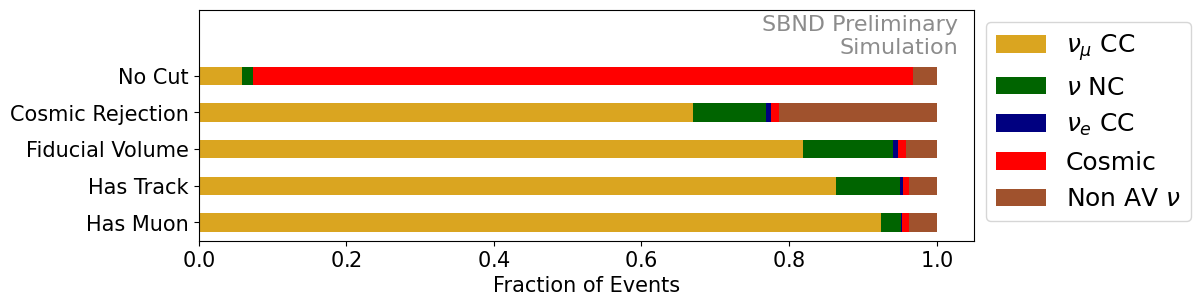

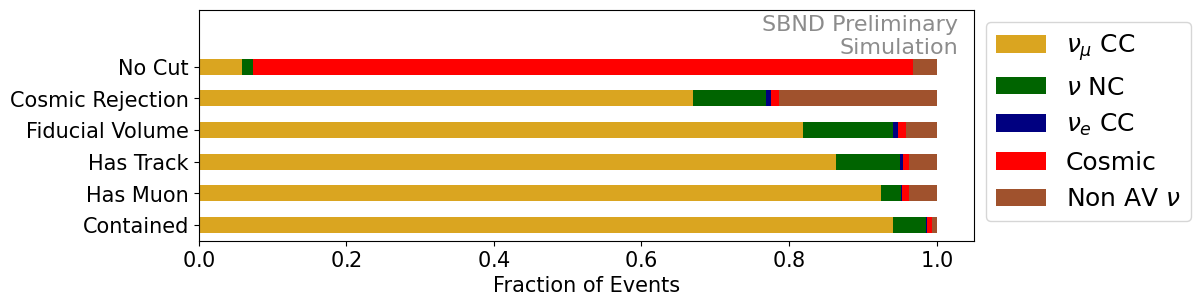

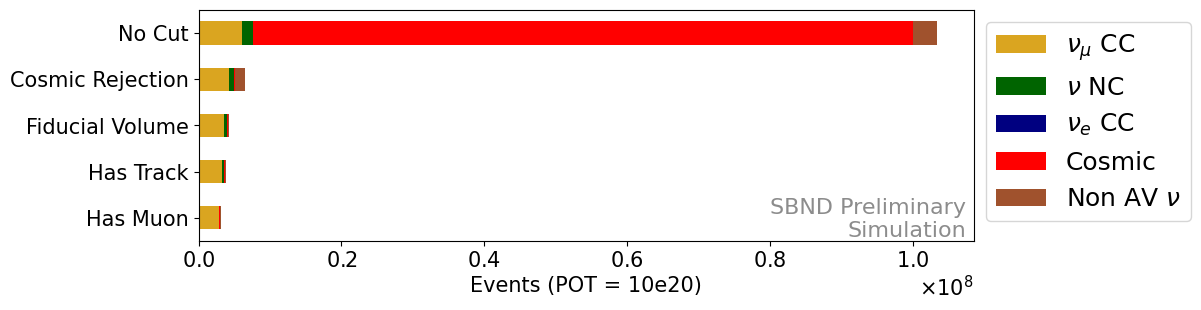

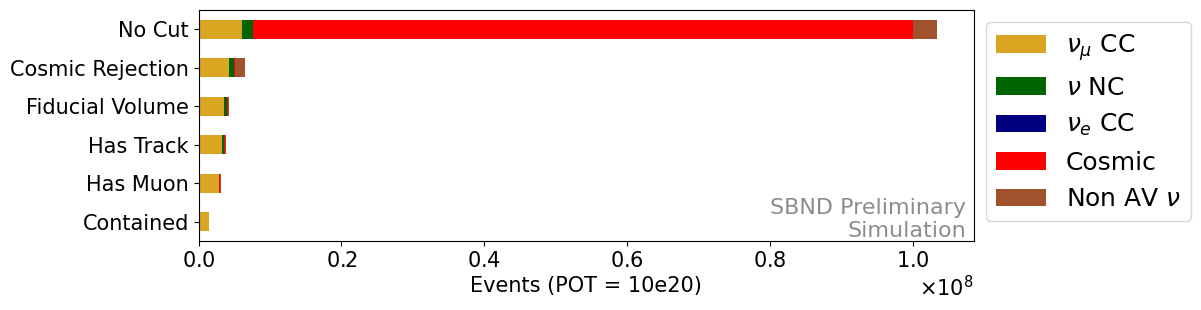

In [11]:
for n in [True,False]:
    for i,cuts in enumerate([CUTS,CUTS_CONT]):
        if i == 0:
            savename = 'cut_bar'
            cut_names = ['No Cut','Cosmic Rejection','Fiducial Volume','Has Track','Has Muon']
        elif i == 1:
            savename = 'cut_cont_bar'
            cut_names = ['No Cut','Cosmic Rejection','Fiducial Volume','Has Track','Has Muon','Contained']
        df = slc.get_events_cuts(cuts,normalize=n)
        ax = make_cut_bar_plot(df,cuts,cut_names,colors=colors)
        if n:
            ax.set_ylim(-0.5,len(cut_names)+0.8)
            ax.set_xlabel('Fraction of Events')
            folder_name = f'{PLOT_DIR}/dens'
            plotters.add_label(ax,LABEL,where='topright',color='gray',alpha=0.9,fontsize=16)
        else:
            plotters.add_label(ax,LABEL,where='bottomright',color='gray',alpha=0.9,fontsize=16)
            ax.set_xlabel(f'Events (POT = {NOM_POT/1e20:.0f}e20)')
            folder_name = f'{PLOT_DIR}/counts'
        if SAVE_PLOT:
            plotters.save_plot(savename,folder_name=folder_name)
            #plt.close()

## 4 Single Particle

In [12]:
#Reco particles and slices
muon,proton,pion = pfp.get_particles([13,2212,211],use_reco=True)
pfps = [muon,proton,pion]
slc_muon = CAFSlice(muon.get_reference_df(slc))
slc_proton = CAFSlice(proton.get_reference_df(slc))
slc_pion = CAFSlice(pion.get_reference_df(slc))
slcs = [slc_muon,slc_proton,slc_pion]

#True particles and slices
tmuon,tproton,tpion = pfp.get_particles([13,2212,211],use_reco=False)
tpfps = [tmuon,tproton,tpion]
slc_tmuon = CAFSlice(tmuon.get_reference_df(slc))
slc_tproton = CAFSlice(tproton.get_reference_df(slc))
slc_tpion = CAFSlice(tpion.get_reference_df(slc))
tslcs = [slc_tmuon,slc_tproton,slc_tpion]

In [13]:
labels = [r'$\mu$',r'$p$',r'$\pi^\pm$']
names = ['muon','proton','pion']
weights = [p.data.genweight for p in tpfps]

In [14]:
#Track score
trkscores = [p.data.trackScore for p in tpfps]


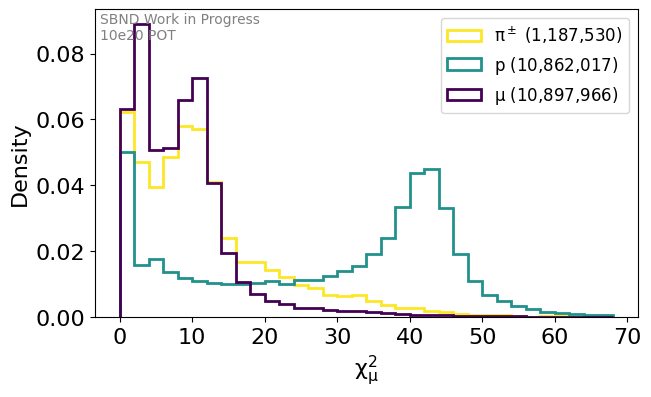

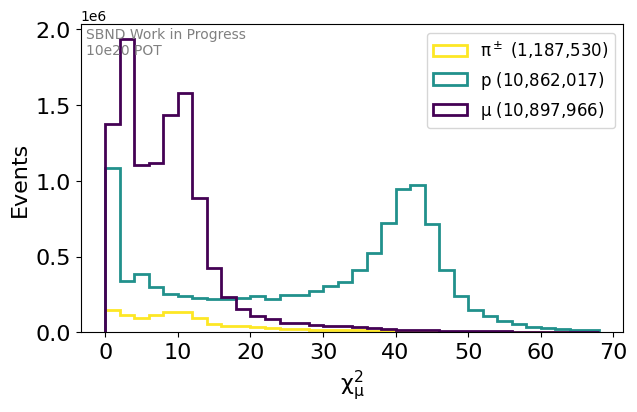

In [15]:
#Chi2 muon
x2_mu = [p.data.trk.chi2pid.I2.chi2_muon for p in tpfps]
bins = np.arange(0,70,2)
for dens in [True,False]:
    fig,ax = makeplot.plot_hist(x2_mu,labels,xlabel=r'$\chi^2_{\mu}$',weights=weights
                                ,histtype='step',lw=2,bins=bins,density=dens)
    if dens: ax.set_ylabel('Density')
    else: ax.set_ylabel('Events')
    plotters.add_label(ax,LABEL,where='topleft',color='gray',fontsize=10)
    plotters.set_style(ax)
    if SAVE_PLOT:
        if dens: plot_dir = f'{PLOT_DIR}/dens'
        else: plot_dir = f'{PLOT_DIR}/counts'
        plotters.save_plot('x2_mu_precut',fig=fig,folder_name=plot_dir)

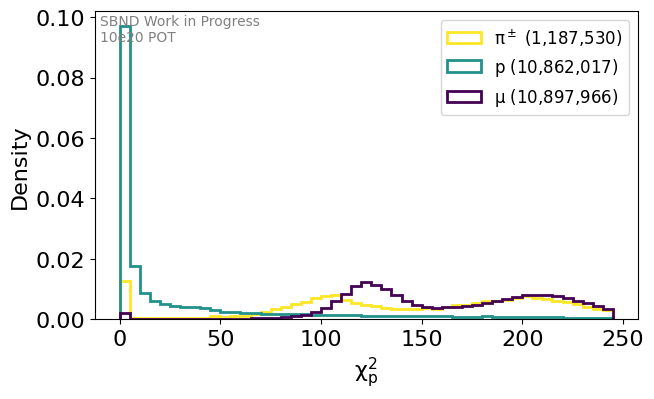

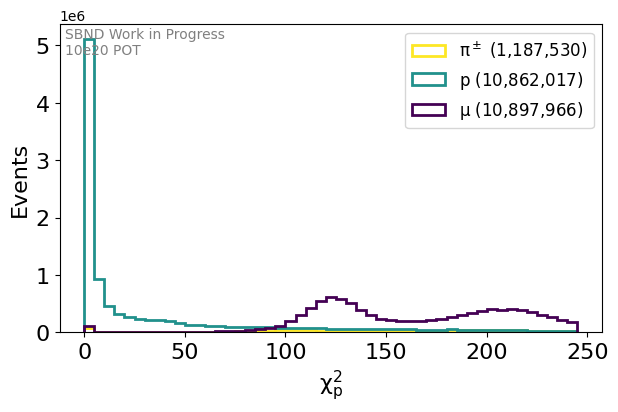

In [16]:
#Chi2 proton
x2_p = [p.data.trk.chi2pid.I2.chi2_proton for p in tpfps]
bins = np.arange(0,250,5)
for dens in [True,False]:
    fig,ax = makeplot.plot_hist(x2_p,labels,xlabel=r'$\chi^2_{p}$',weights=weights
                                ,histtype='step',lw=2,bins=bins,density=dens)
    if dens: ax.set_ylabel('Density')
    else: ax.set_ylabel('Events')
    plotters.add_label(ax,LABEL,where='topleft',color='gray',fontsize=10)
    plotters.set_style(ax)
    if SAVE_PLOT:
        if dens: plot_dir = f'{PLOT_DIR}/dens'
        else: plot_dir = f'{PLOT_DIR}/counts'
        plotters.save_plot('x2_p_precut',fig=fig,folder_name=plot_dir)

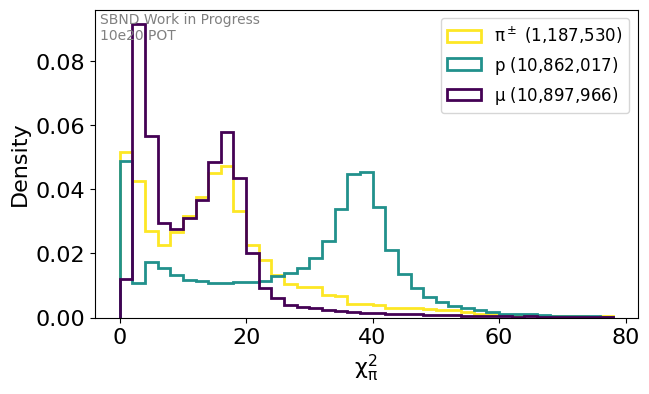

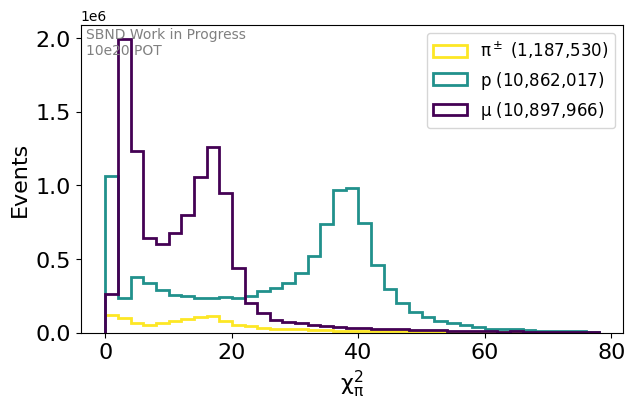

In [17]:
#Chi2 pion
x2_pi = [p.data.trk.chi2pid.I2.chi2_pion for p in tpfps]
bins = np.arange(0,80,2)
for dens in [True,False]:
    fig,ax = makeplot.plot_hist(x2_pi,labels,xlabel=r'$\chi^2_{\pi}$',weights=weights
                                ,histtype='step',lw=2,bins=bins,density=dens)
    if dens: ax.set_ylabel('Density')
    else: ax.set_ylabel('Events')
    plotters.add_label(ax,LABEL,where='topleft',color='gray',fontsize=10)
    plotters.set_style(ax)
    if SAVE_PLOT:
        if dens: plot_dir = f'{PLOT_DIR}/dens'
        else: plot_dir = f'{PLOT_DIR}/counts'
        plotters.save_plot('x2_pion_precut',fig=fig,folder_name=plot_dir)

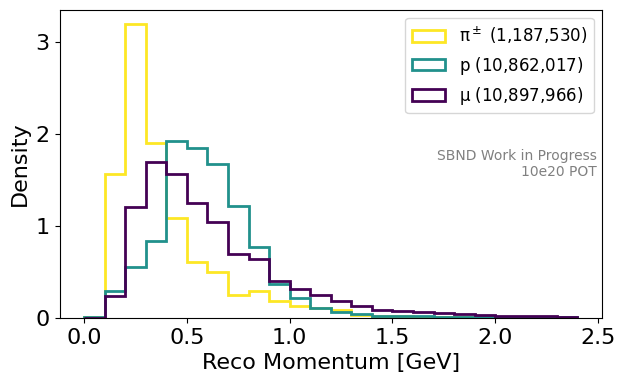

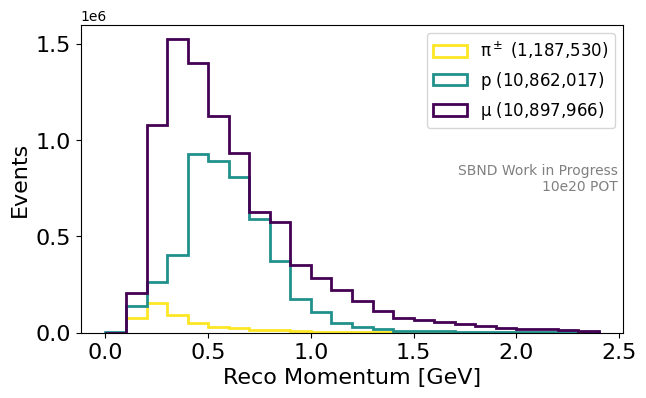

In [18]:
#Particle momentum
momenta = [p.data.trk.bestmom for p in tpfps]
bins = np.arange(0,2.5,0.1)
for dens in [True,False]:
    fig,ax = makeplot.plot_hist(momenta,labels,xlabel=r'Reco Momentum [GeV]',weights=weights
                                ,histtype='step',lw=2,bins=bins,density=dens)
    if dens: ax.set_ylabel('Density')
    else: ax.set_ylabel('Events')
    plotters.add_label(ax,LABEL,where='centerright',color='gray',fontsize=10)
    plotters.set_style(ax)
    if SAVE_PLOT:
        if dens: plot_dir = f'{PLOT_DIR}/dens'
        else: plot_dir = f'{PLOT_DIR}/counts'    
        plotters.save_plot('particle_momentum_precut',fig=fig,folder_name=plot_dir)

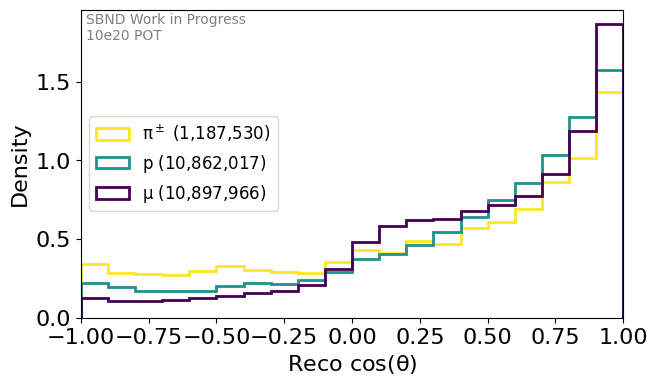

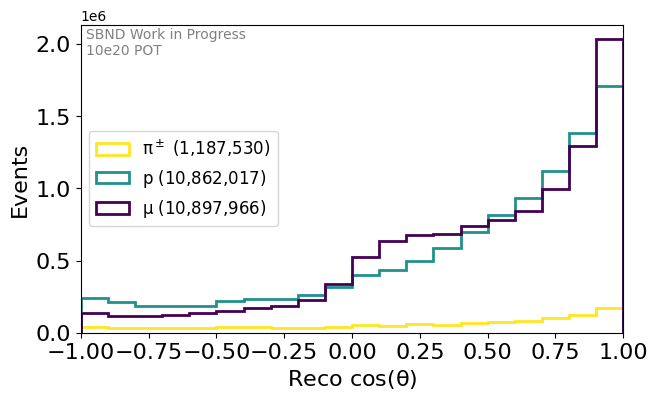

In [19]:
#Particle direction cos theta
costhetas = [np.cos(p.data.trk.theta) for p in tpfps]
bins = np.arange(-1,1.1,0.1)
for dens in [True,False]:
    fig,ax = makeplot.plot_hist(costhetas,labels,xlabel=r'Reco cos($\theta$)',weights=weights
                                ,histtype='step',lw=2,bins=bins,density=dens)
    ax.set_xlim(-1,1)
    if dens: ax.set_ylabel('Density')
    else: ax.set_ylabel('Events')
    plotters.add_label(ax,LABEL,where='topleft',color='gray',fontsize=10)
    plotters.set_style(ax)
    if SAVE_PLOT:
        if dens: plot_dir = f'{PLOT_DIR}/dens'
        else: plot_dir = f'{PLOT_DIR}/counts'    
        plotters.save_plot('particle_costheta_precut',fig=fig,folder_name=plot_dir)

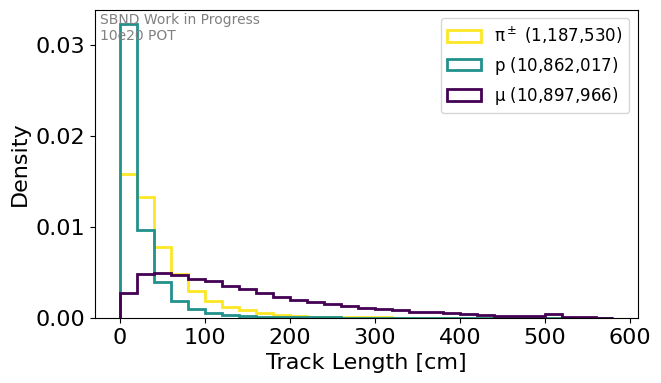

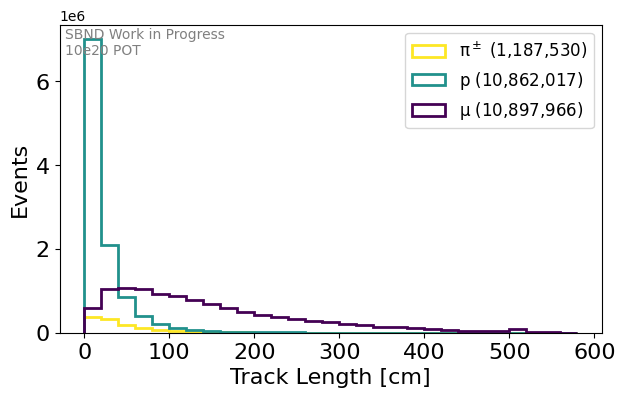

In [20]:
#Particle length
lengths = [p.data.trk.len for p in tpfps]
bins = np.arange(0,600,20)
for dens in [True,False]:
    fig,ax = makeplot.plot_hist(lengths,labels,xlabel=r'Track Length [cm]',weights=weights
                                ,histtype='step',lw=2,bins=bins,density=dens)
    if dens: ax.set_ylabel('Density')
    else: ax.set_ylabel('Events')
    plotters.add_label(ax,LABEL,where='topleft',color='gray',fontsize=10)
    plotters.set_style(ax)
    if SAVE_PLOT:
        if dens: plot_dir = f'{PLOT_DIR}/dens'
        else: plot_dir = f'{PLOT_DIR}/counts'    
        plotters.save_plot('particle_length_precut',fig=fig,folder_name=plot_dir)